In [ ]:
# install lime in colab
!pip install lime==0.1.1.37

In [1]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from torch.autograd import Variable

d:\ProgrammingSoftwares\Anaconda3\envs\pytorch39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food/'
}
args = argparse.Namespace(**args)

## Model Definition and Checkpoint Loading

In [3]:
# Model definition
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.ReLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(nn.MaxPool2d(2, 2, 0))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = nn.Sequential( * cnn_list)

    dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
    self.fc = nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = out.reshape(out.size()[0], -1)
    return self.fc(out)

In [4]:
# Load trained model
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])
# It should display: <All keys matched successfully> 

<All keys matched successfully>

In [5]:
from torchsummary import summary

model_show = Classifier().to('cuda')
summary(model_show, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           3,584
       BatchNorm2d-2        [-1, 128, 128, 128]             256
              ReLU-3        [-1, 128, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]         147,584
       BatchNorm2d-5        [-1, 128, 128, 128]             256
              ReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]         147,584
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 128,

## Dataset Definition and Creation

In [5]:
# It might take some time, if it is too long, try to reload it.
# Dataset definition
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # pytorch dataset class
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# help to get data path and label
def get_paths_labels(path):
    def my_key(name):
      return int(name.replace(".jpg","").split("_")[1])+1000000*int(name.split("_")[0])
    imgnames = os.listdir(path)
    imgnames.sort(key=my_key)
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels


train_paths, train_labels = get_paths_labels(args.dataset_dir)
train_set = FoodDataset(train_paths, train_labels, mode='eval')

In [41]:
train_paths

['./food/0_0.jpg',
 './food/1_1.jpg',
 './food/1_2.jpg',
 './food/2_3.jpg',
 './food/2_4.jpg',
 './food/3_5.jpg',
 './food/5_6.jpg',
 './food/6_7.jpg',
 './food/8_8.jpg',
 './food/9_9.jpg']

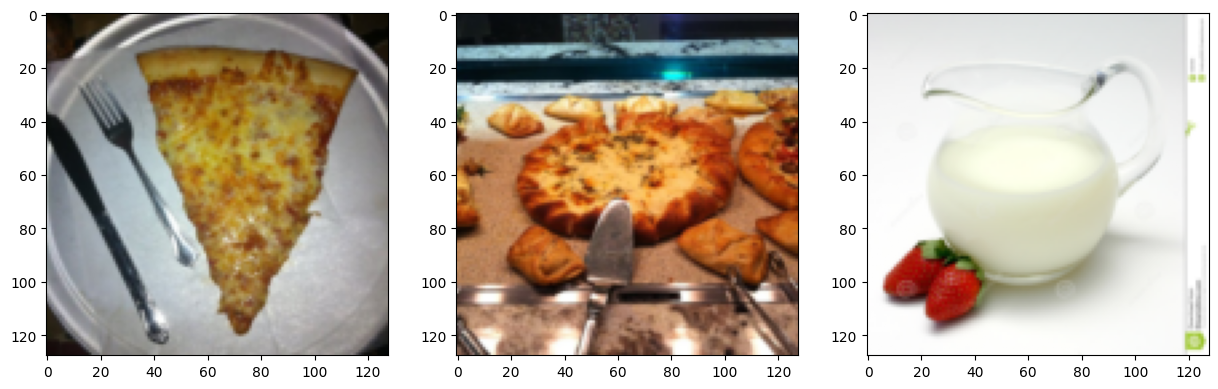

In [95]:
img_indices = [i for i in range(3)]
# img_indices = [i for i in range(10)]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 15))
for i, img in enumerate(images):
  axs[i].imshow(img.cpu().permute(1, 2, 0))
# print(labels) # this line can help you know the labels of each image

# Local Explanation I – which part is important? 
[Lime](https://github.com/marcotcr/lime) 

100% |########################################################################|
100% |########################################################################|


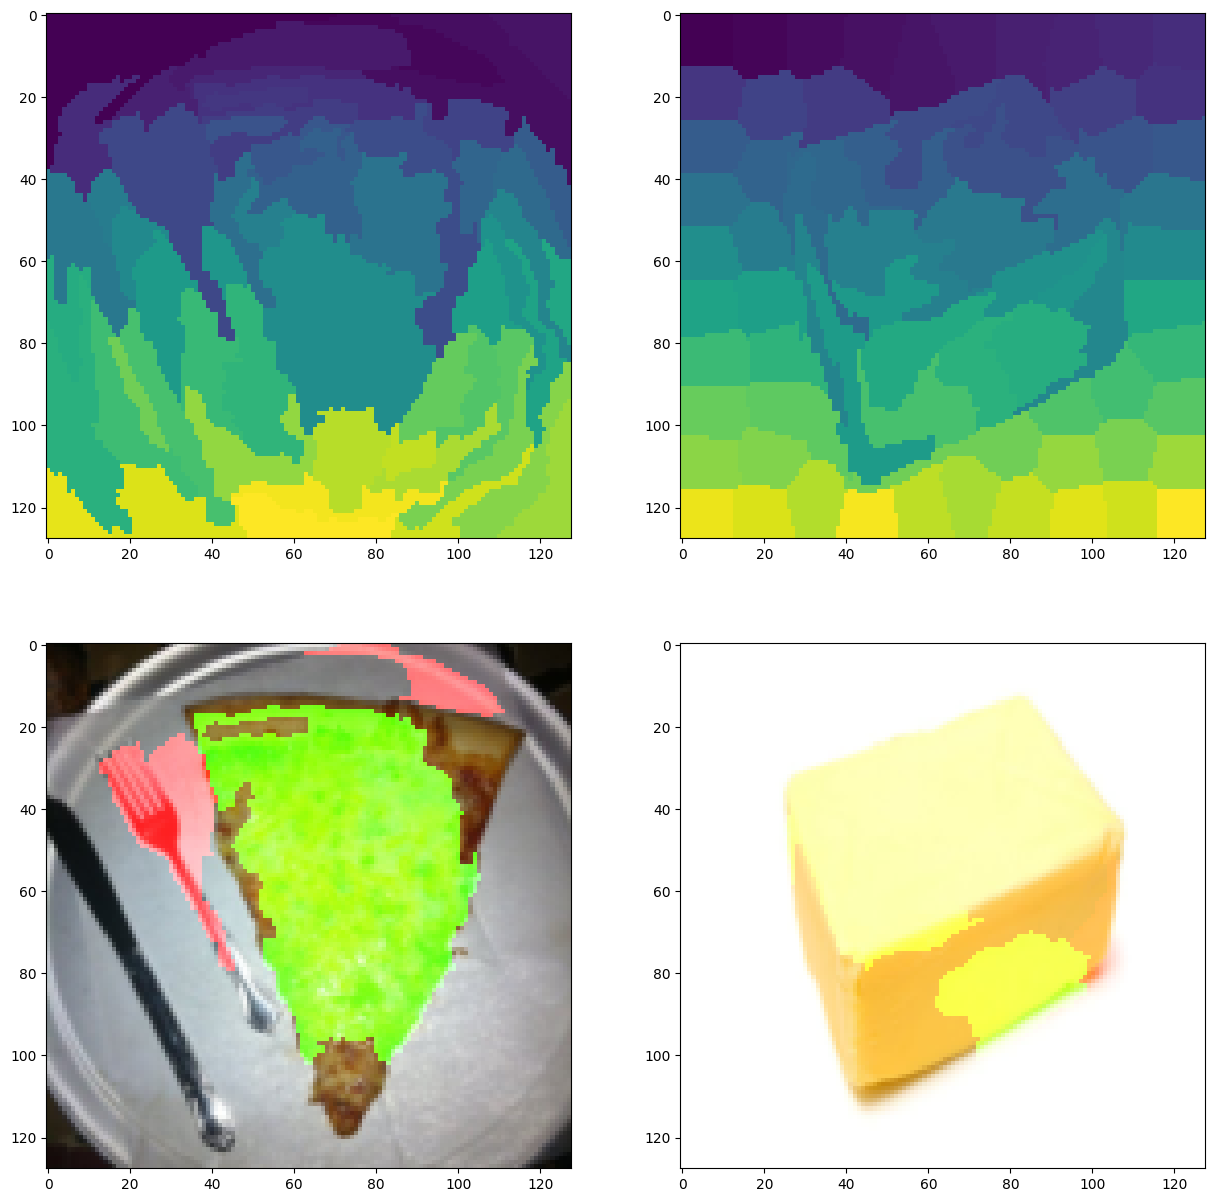

In [7]:
from skimage.segmentation import slic, mark_boundaries

def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # pytorch tensor, (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage                                                                                                                   
    return slic(input, n_segments=100, compactness=1, sigma=1, start_label=1)                                                                                                              

                                                                                                                                                                  

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 15))                                                                                                                                                                 
# fix the random seed to make it reproducible
np.random.seed(16)                                                                                                                                                       
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # numpy array for lime

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)


    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                            
                            )
  
    segments = segmentation(x)
    axs[0,idx].imshow(segments)
    axs[1,idx].imshow(lime_img)

plt.show()
plt.close()

# Local Explanation II – Saliency map 

What is Saliency map ?

Saliency: 顯著性

The heatmaps that highlight pixels of the input image that contribute the most in the classification task.

Ref: https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

In [25]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())
  # return torch.log(image)/torch.log(image.max())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda() # [2,3,128,128]

  # we want the gradient of the input x
  x.requires_grad_()
  
  y_pred = model(x) # [2,11]
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  # saliencies = x.grad.abs().detach().cpu()
  saliencies, index = torch.max(x.grad.data.abs().detach().cpu(),dim=1) # [2,3,128,128] => [2,128,128]
  

  # We need to normalize each image, because their gradients might vary in scale
  saliencies = torch.stack([normalize(item) for item in saliencies]) # [2,128,128]
  return saliencies

saliencies = compute_saliency_maps(images, labels, model)


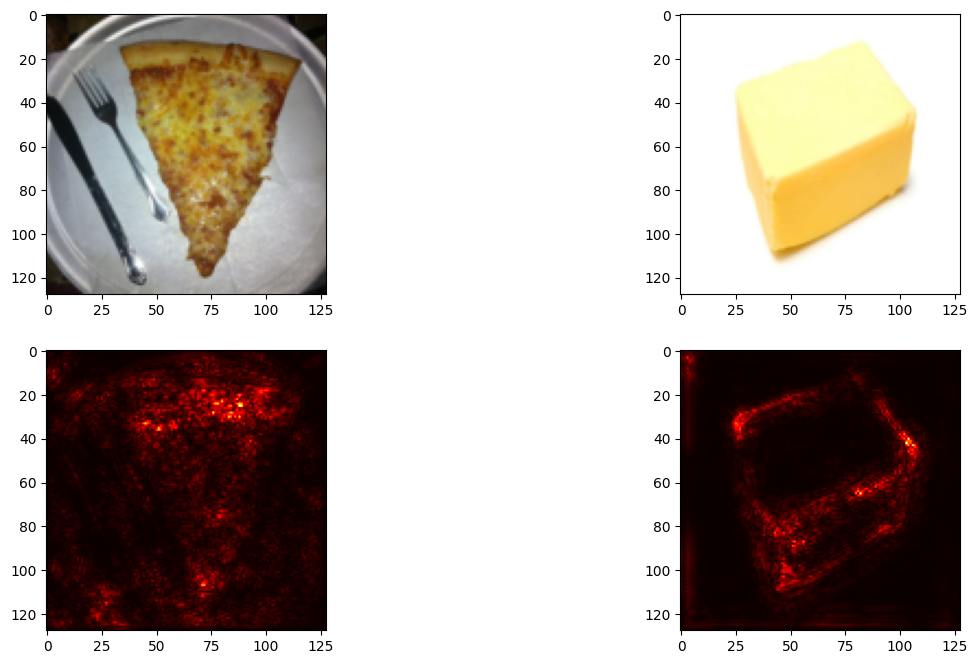

In [26]:
# images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    if row==0:
      axs[row][column].imshow(img.permute(1, 2, 0).numpy())
      # What is permute?
      # In pytorch, the meaning of each dimension of image tensor is (channels, height, width)
      # In matplotlib, the meaning of each dimension of image tensor is (height, width, channels)
      # permute is a tool for permuting dimensions of tensors
      # For example, img.permute(1, 2, 0) means that,
      # - 0 dimension is the 1 dimension of the original tensor, which is height
      # - 1 dimension is the 2 dimension of the original tensor, which is width
      # - 2 dimension is the 0 dimension of the original tensor, which is channels
    else:
      axs[row][column].imshow(img.numpy(), cmap=plt.cm.hot)
    
plt.show()
plt.close()

## Local Explanation III – Smooth Grad

The method of Smooth grad is to randomly add noise to the image and get different heatmaps. The average of the heatmaps would be more robust to noisy gradient.

ref: https://arxiv.org/pdf/1706.03825.pdf

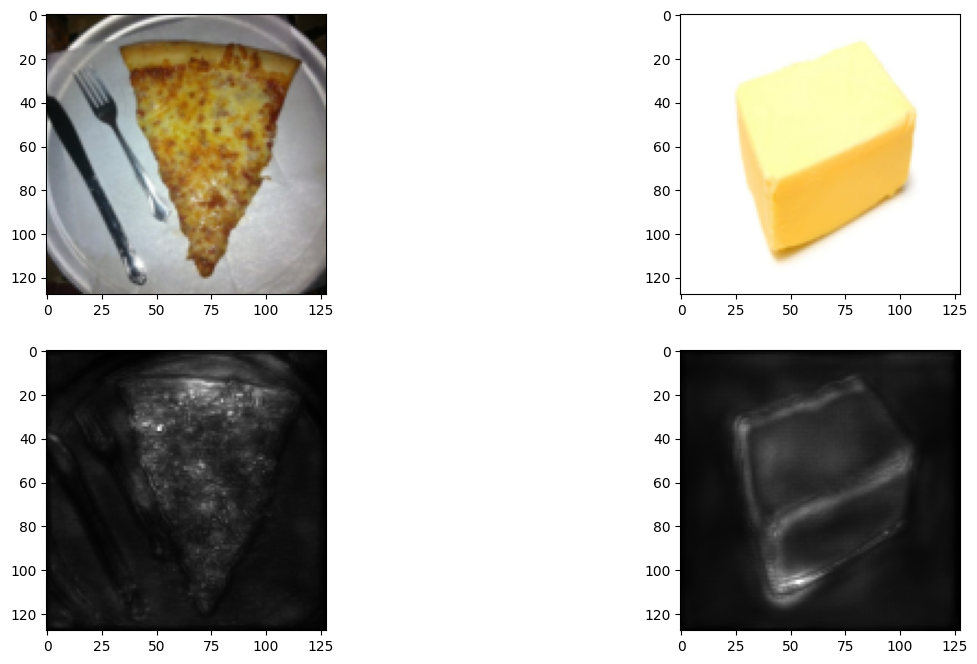

In [43]:
# Smooth grad

def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def smooth_grad(x, y, model, epoch, param_sigma_multiplier): # image label model 500 0.4
  model.eval()

  mean = 0
  sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
  smooth = np.zeros(x.cuda().unsqueeze(0).size())
  for i in range(epoch):
    # call Variable to generate random noise
    noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
    x_mod = (x+noise).unsqueeze(0).cuda()
    x_mod.requires_grad_()

    y_pred = model(x_mod)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda().unsqueeze(0))
    loss.backward()

    # like the method in saliency map
    # smooth += x_mod.grad.abs().detach().cpu().data.numpy()
    saliencies, _ = torch.max(x_mod.grad.data.abs().detach().cpu(),dim=1) # [2,3,128,128] => [2,128,128]
    # x_mod_grad = torch.from_numpy(x_mod.grad.data.abs().detach().cpu().data.numpy())
    
    smooth += saliencies.numpy()

    # smooth += torch.max(x_mod.grad.data.abs().detach().cpu().data,dim=1)
  smooth = normalize(smooth / epoch) # don't forget to normalize
  # smooth = smooth / epoch # try this line to answer the question
  return smooth


# images, labels = train_set.getbatch(img_indices)
smooth = []
for i, l in zip(images, labels):
  smooth.append(smooth_grad(i, l, model, 500, 0.2))
smooth = np.stack(smooth)
# print(smooth.shape)

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, smooth]):
  for column, img in enumerate(target):
    axs[row][column].imshow(np.transpose(img.reshape(3,128,128), (1,2,0)), cmap=plt.cm.hot)

## Gobal Explanation – Filter explanation   

In this part, we want to know what a specific filter recognize, we'll do
- Filter activation: pick up some images, and check which part of the image activates the filter
- Filter visualization: look for which kind of image can activate the filter the most

How can we get the output of a specific layer of CNN? 

We can modify the model definition, make the forward function not only return loss but also retrun the activation map. But this is difficult to maintain the code. As a result, pytorch offers a better solution: **hook**


In [12]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [45]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explanation(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: input image
  # cnnid: cnn layer id
  # filterid: which filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output
  
  hook_handle = model.cnn[cnnid].register_forward_hook(hook)
  # When the model forwards through the layer[cnnid], it needs to call the hook function first
  # The hook function save the output of the layer[cnnid]
  # After forwarding, we'll have the loss and the layer activation

  # Filter activation: x passing the filter will generate the activation map
  model(x.cuda()) # forward

  # Based on the filterid given by the function argument, pick up the specific filter's activation map
  # We just need to plot it, so we can detach from graph and save as cpu tensor
  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
  
  # Filter visualization: find the image that can activate the filter the most
  x = x.cuda()
  x.requires_grad_()
  # input image gradient
  optimizer = Adam([x], lr=lr)
  # Use optimizer to modify the input image to amplify filter activation
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)
    
    objective = -layer_activations[:, filterid, :, :].sum()
    # We want to maximize the filter activation's summation
    # So we add a negative sign
    
    objective.backward()
    # Calculate the partial differential value of filter activation to input image
    optimizer.step()
    # Modify input image to maximize filter activation
  filter_visualizations = x.detach().cpu().squeeze()

  # Don't forget to remove the hook
  hook_handle.remove()
  # The hook will exist after the model register it, so you have to remove it after used
  # Just register a new hook if you want to use it

  return filter_activations, filter_visualizations

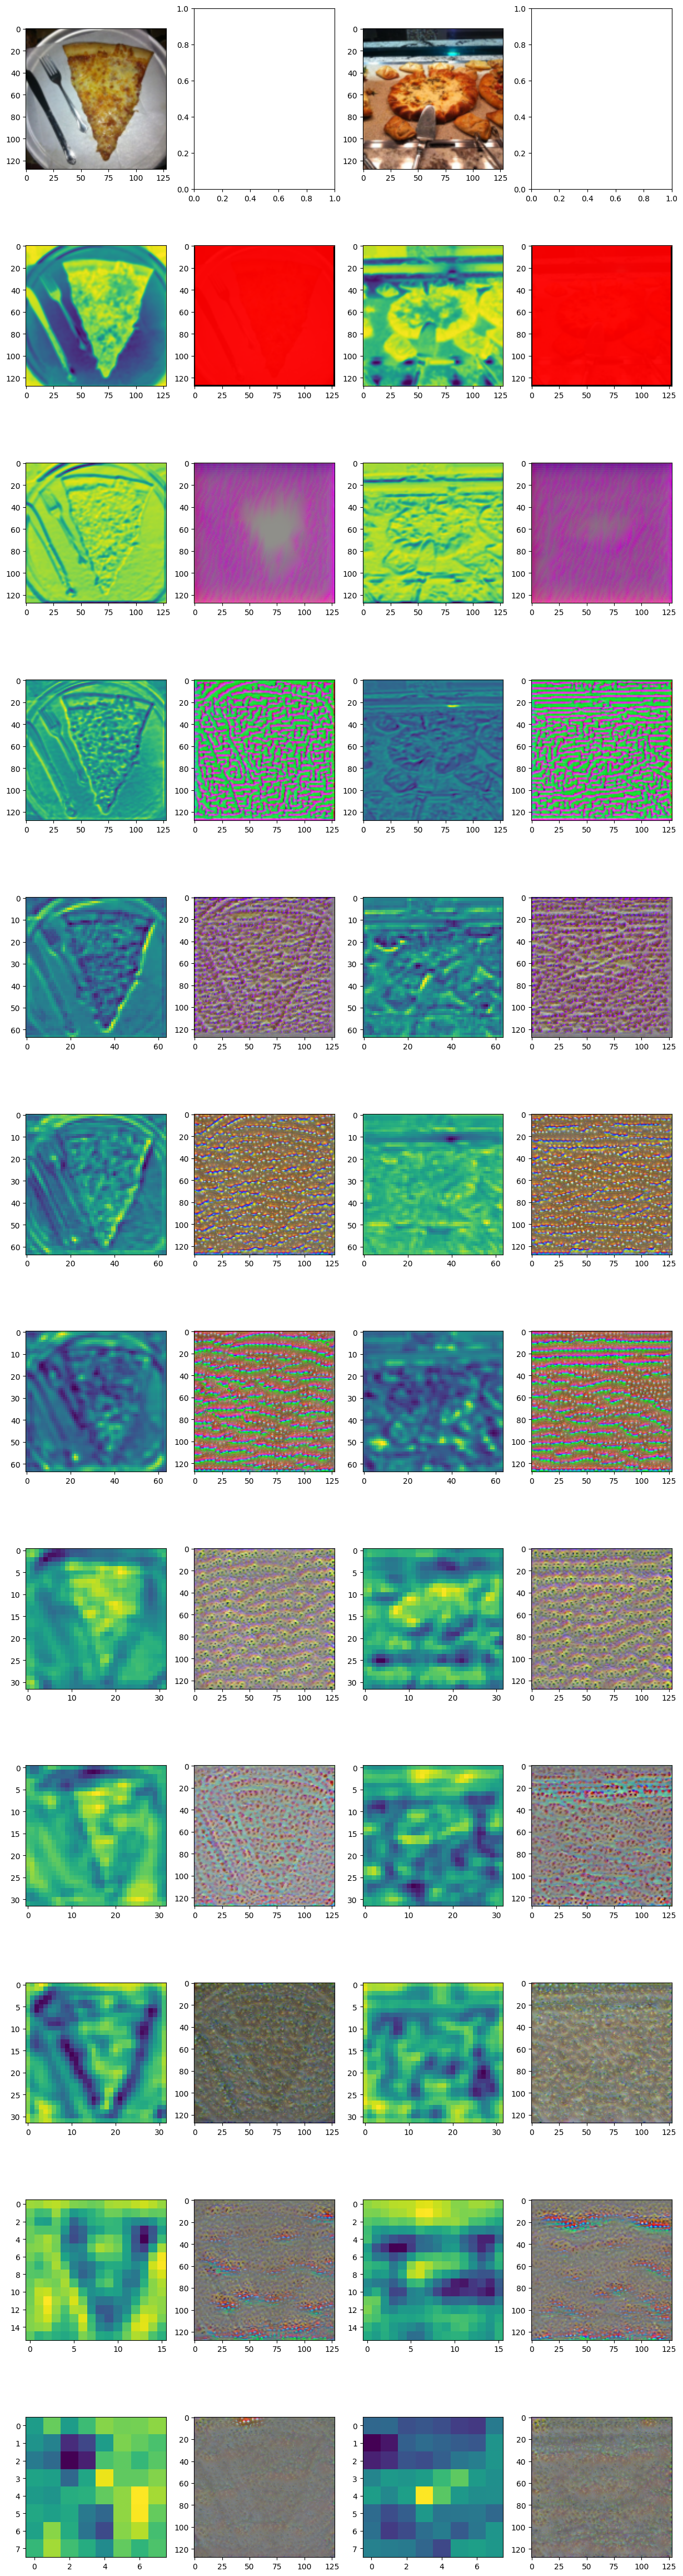

In [84]:
images, labels = train_set.getbatch(img_indices)

fig, axs = plt.subplots(12, len(img_indices)*2, figsize=(15, 60))
for i, img in enumerate(images):
  axs[0][2*i].imshow(img.permute(1, 2, 0))

cnn_layers = [1, 4, 7, 11, 14, 17, 21, 24, 27, 31, 35]
for item in range(11):
  row = cnn_layers[item]
  filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=row, filterid=1, iteration=100, lr=0.1)

  # Plot filter activations
  for i, img in enumerate(filter_activations):
    axs[item+1][2*i].imshow(normalize(img))
  # Plot filter visualization
  for i, img in enumerate(filter_visualizations):
    axs[item+1][2*i+1].imshow(normalize(img.permute(1, 2, 0)))

  
plt.show()
plt.close()

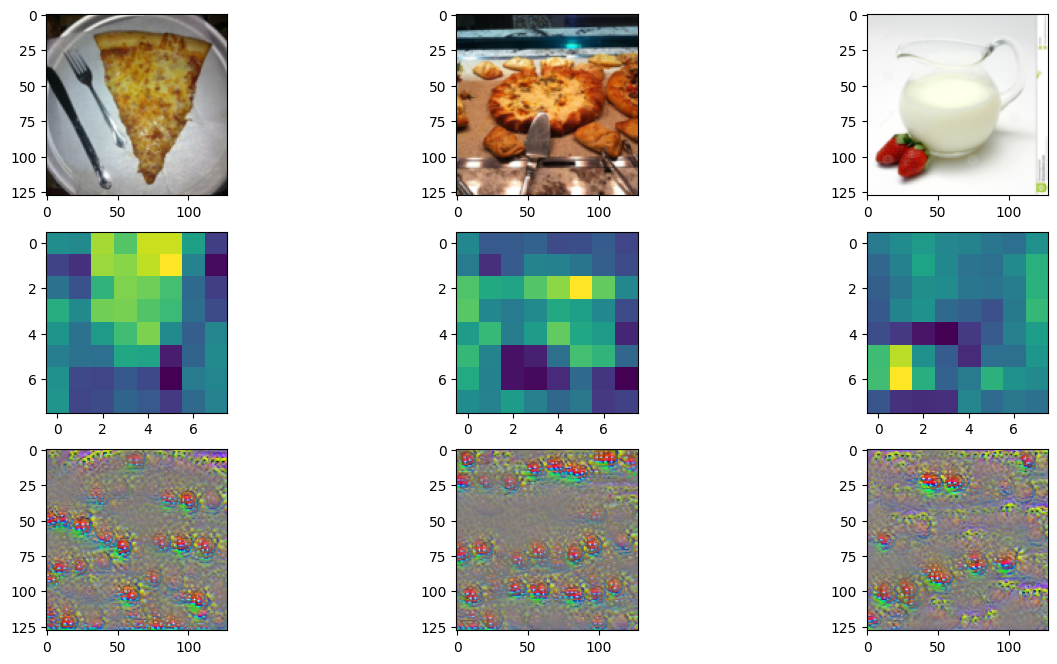

In [98]:

images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=34, filterid=0, iteration=100, lr=0.1)

# Plot filter activations
fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
for i, img in enumerate(filter_visualizations):
  axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()
